In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("C:\\Users\\Rafal\\Desktop\\machine_learning\\mckinsey_lamoda\\EDA\\final_subset (1).csv", low_memory=False, parse_dates=['date'])

In [3]:
data_raw = data.copy()

In [9]:
data_raw.isnull().sum()/len(data_raw)

landing_page        0.000000
channel             0.000000
device              0.000000
city                0.000000
transactions        0.000000
cookie              0.000000
date                0.000000
product_id          0.000000
category_id         0.000000
subcategory_id      0.000000
brand               0.000000
price               0.000079
base_price          0.000000
discount_percent    0.000079
category_name       0.013196
product_name        0.013196
dtype: float64

In [4]:
data_raw = data_raw[~data_raw.cookie.isna()]

In [5]:
sum(data_raw.transactions == 0)/len(data_raw.transactions)

0.15630065805904375

klasy są niezbalansowane

In [6]:
data_raw['transactions_bin'] = [1 if i>0 else 0 for i in data_raw['transactions'].values]

### Landing page

In [7]:
data_raw['landing_page_split'] = data_raw['landing_page'].apply(lambda x: x.split('/'))
data_raw['landing_page_first'] = [x[1] if len(x) > 1 else x[0] for x in data_raw['landing_page_split'].values]
data_raw['landing_page_length'] = data_raw['landing_page_split'].apply(lambda x: len(x))

### Cookie

In [45]:
data_raw['cookie_cat'] = ['float' if type(c) == float else
                      'hash' if '%hash%' in c else
                      'alphanum' if re.search('[a-z]', c) is not None else
                      'dot' if '.' in c else 'other'
                      for c in data_raw['cookie'].values]

### Date

In [43]:
attr = ['Dayofweek', 'Is_month_end', 'Is_month_start', 'Day'] 
for n in attr: data_raw['Date_' + n] = getattr(data_raw.date.dt, n.lower())

In [44]:
data_raw.Date_Dayofweek = data_raw.Date_Dayofweek.astype('object')
data_raw.Date_Day = data_raw.Date_Day.astype('object')

### Podsumowania dla zmiennych

In [8]:
def basic_stat(df, zmienna, q=0.99, detailed = True, discretize=False, show=True):
    '''
    Przed odpaleniem trzeba zdefiniowac zmienna transactions_bin: 
    df['transactions_bin'] = [1 if i>0 else 0 for i in df['transactions'].values]
    Zwraca podsumowanie w formie histogramu dla danej zmiennej numerycznej z podziałem na transakcje (trans) i ich brak (no_trans), 
    lub w formie zestackowanego histogramu dla kazdej kategorii zmiennej kategorycznej (kategoryczna jako dtype 'object').
    Jesli zmienna kategoryczna ma wiecej niz 10 kategorii, zwraca podsumowanie dla 10 najczestszych.
    
    df - dataframe z danymi
    zmienna - zmienna do podsumowania (tylko typy: float64, int64, object, bool - jak dodałem 'category' do drugiego ifa, wyrzucało mi dziwne warningi przy sprawdzaniu innych zmiennych)
    '''
    df_temp = df.copy()
    if df[zmienna].dtype in ('float64', 'int64') and discretize==False: 
        bins = np.linspace(df[zmienna].min(), df[zmienna].quantile(q), 50)
        plt.hist(df[df.transactions_bin==0][zmienna], bins, alpha=0.5, label='no_trans')
        plt.hist(df[df.transactions_bin==1][zmienna], bins, alpha=0.5, label='trans')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f'Transactions distribution in {zmienna} variable')
        if show:
            plt.show()
        if detailed:
            temp = df[df.transactions_bin==0][zmienna]
            temp2 = df[df.transactions_bin==1][zmienna]
            print(pd.DataFrame(data=[temp.describe().append(pd.Series(data = [temp.skew(), temp.kurtosis()],index=['skewness', 'kurtosis'])),
                                     temp2.describe().append(pd.Series(data = [temp2.skew(), temp2.kurtosis()],index=['skewness', 'kurtosis']))],
                               index=['no trans', 'trans']).T)
    if discretize:
        df_temp[zmienna]=df_temp[zmienna].astype('object')
    if df_temp[zmienna].dtype in ('object', 'bool'):
        if len(df_temp[zmienna].unique()) > 10:
            most_freq_keys = df_temp[zmienna].dropna().value_counts()[:10].index
        else:
            most_freq_keys = df_temp[zmienna].dropna().unique()
        zero_vals=[len(df[(df_temp[zmienna] == i) & (df_temp.transactions_bin == 0)]) for i in most_freq_keys]
        one_vals_perc=[round((len(df_temp[(df_temp[zmienna] == i) & (df_temp.transactions_bin == 1)])/len(df_temp[df_temp[zmienna]== i])*100),2) for i in most_freq_keys]
        one_vals=[len(df_temp[(df_temp[zmienna] == i) & (df_temp.transactions_bin == 1)]) for i in most_freq_keys]
        plt.figure(figsize=(8, 5))
        p1 = plt.bar(most_freq_keys, one_vals, 0.5, tick_label=one_vals)
        p2 = plt.bar(most_freq_keys, zero_vals, 0.5, bottom=one_vals)
        plt.ylabel('Freq')
        plt.title(f'Transactions distribution in cats of {zmienna} variable')
        plt.xticks(most_freq_keys, most_freq_keys, rotation=90)
        plt.legend((p1[0], p2[0]), ('trans', 'no_trans'), loc='center left', bbox_to_anchor=(1, 0.5))
        for bar1, bar2 in zip(p1, p2):
            height = bar1.get_height() + bar2.get_height()
            perc = (bar1.get_height()/(height))*100
            plt.text(bar1.get_x()+bar1.get_width()/2, 1.005*height,
                    '%.2f'%perc+'%',
                    ha='center', va='bottom')
        if show:
            plt.show()
        if detailed:
            print(pd.DataFrame(data={f'{zmienna}': most_freq_keys,
                                    'procent_klikniec': one_vals_perc}).sort_values('procent_klikniec', ascending=False))

## Analiza zmiennych na podstawie których dzielono

### Landing page length

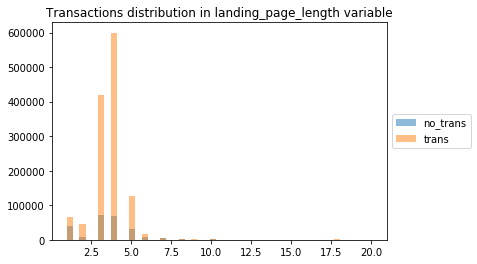

               no trans         trans
count     238444.000000  1.287103e+06
mean           3.608311  3.657034e+00
std            2.234363  1.389393e+00
min            1.000000  1.000000e+00
25%            3.000000  3.000000e+00
50%            4.000000  4.000000e+00
75%            4.000000  4.000000e+00
max           44.000000  9.500000e+01
skewness       4.998202  8.101729e+00
kurtosis      50.477543  2.109422e+02


In [13]:
basic_stat(data_raw, 'landing_page_length', q=0.999)

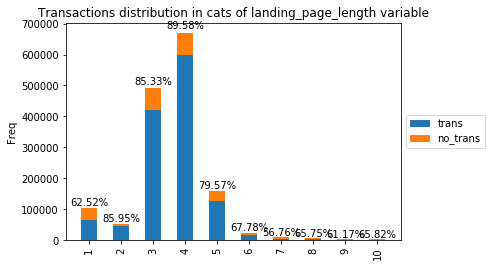

   landing_page_length  procent_klikniec
0                    4             89.58
4                    2             85.95
1                    3             85.33
2                    5             79.57
5                    6             67.78
8                   10             65.82
7                    8             65.75
3                    1             62.52
9                    9             61.17
6                    7             56.76


In [263]:
basic_stat(data_raw, 'landing_page_length', discretize=True)

In [14]:
lan_page_ones = [len(data_raw[(data_raw.landing_page_length==i) & (data_raw.transactions_bin==1)])/len(data_raw[data_raw.landing_page_length==i]) for i in np.sort(data_raw.landing_page_length.unique())]
lan_page_df = pd.DataFrame(data={'landing_page_length':np.sort(data_raw.landing_page_length.unique()),
                                 'num_of_obs':[len(data_raw[data_raw.landing_page_length==i]) for i in np.sort(data_raw.landing_page_length.unique())],
                                 'ones_percentage':lan_page_ones
                                })
lan_page_df.head()


,landing_page_length,num_of_obs,ones_percentage
0,1,104279,0.625179
1,2,52210,0.859491
2,3,491183,0.853309
3,4,669335,0.895803
4,5,157995,0.795715


In [ ]:
lan_page_df.sort_values('ones_percentage')

procent transakcji dla kolejnych dlugosci landing page'a, pokolorowany wedlug liczebnosci obserwacji (zielony (duzo), przechodzacy w czerwony (malo))

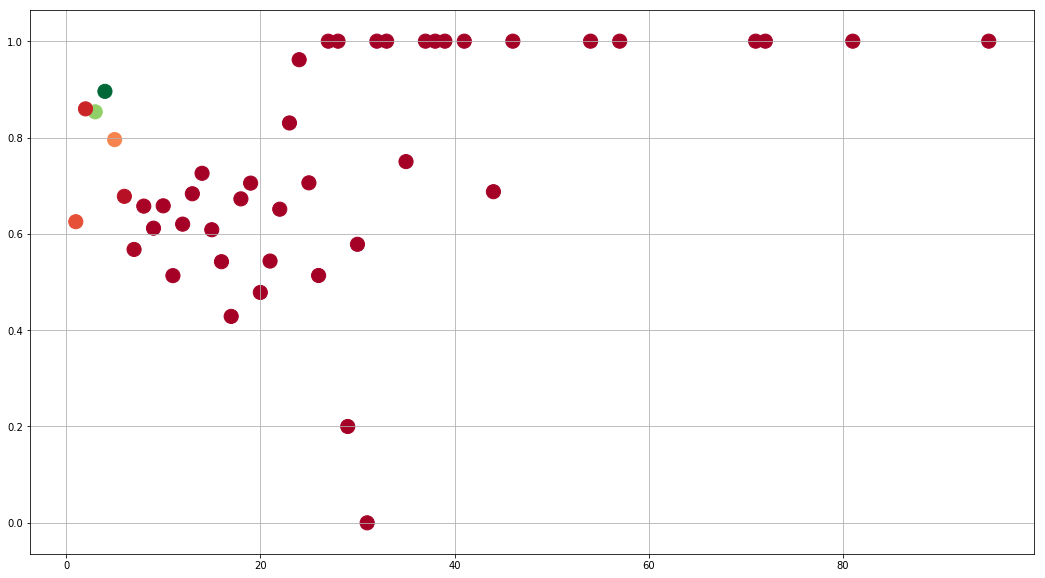

In [77]:
x = lan_page_df.sort_values('ones_percentage').landing_page_length
y = lan_page_df.sort_values('ones_percentage').ones_percentage
z = lan_page_df.sort_values('ones_percentage').num_of_obs
plt.figure(figsize=(18,10))
p_page = plt.subplot()
p_page.scatter(x,y, c=z, s=200, cmap='RdYlGn')
plt.grid(True)
plt.show()

### Marketing channel

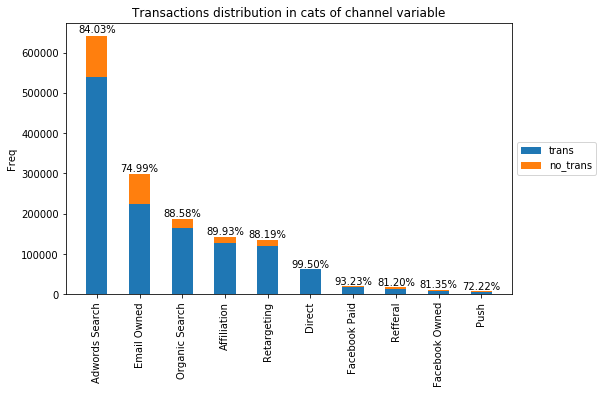

          channel  procent_klikniec
5          Direct             99.50
6   Facebook Paid             93.23
3     Affiliation             89.93
2  Organic Search             88.58
4     Retargeting             88.19
0  Adwords Search             84.03
8  Facebook Owned             81.35
7        Refferal             81.20
1     Email Owned             74.99
9            Push             72.22


In [78]:
basic_stat(data_raw, 'channel')

In [184]:
market_channel_ones = [len(data_raw[(data_raw.channel==i) & (data_raw.transactions_bin==1)])/len(data_raw[data_raw.channel==i]) for i in np.sort(data_raw.channel.unique())]
channel_df = pd.DataFrame(data={'market_channel':np.sort(data_raw.channel.unique()),
                                 'num_of_obs':[len(data_raw[data_raw.channel==i]) for i in data_raw.channel.unique()],
                                 'ones_percentage':market_channel_ones
                                })
channel_df.head()

,market_channel,num_of_obs,ones_percentage
0,(Other),625,0.678400
1,Adwords GDN,51,0.843137
2,Adwords Search,642060,0.840308
3,Affiliation,142443,0.899321
4,Direct,62329,0.995026


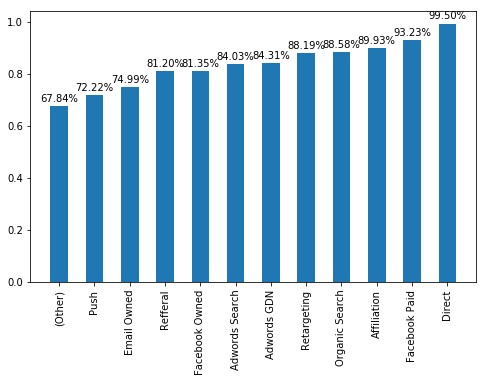

In [26]:
plt.figure(figsize=(8, 5))
p1 = plt.bar(channel_df.sort_values('ones_percentage').market_channel, channel_df.sort_values('ones_percentage').ones_percentage, 0.5)
plt.xticks(channel_df.sort_values('ones_percentage').market_channel, rotation=90)
for bar in p1:
    height = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, 1.01*height,
                    '%.2f'%(height*100)+'%',
                    ha='center', va='bottom')
plt.show()

In [185]:
channel_df.sort_values('ones_percentage', ascending=False)

,market_channel,num_of_obs,ones_percentage
4,Direct,62329,0.995026
7,Facebook Paid,19873,0.932320
3,Affiliation,142443,0.899321
8,Organic Search,186997,0.885752
11,Retargeting,135466,0.881948
1,Adwords GDN,51,0.843137
2,Adwords Search,642060,0.840308
6,Facebook Owned,11643,0.813450
10,Refferal,17563,0.812048
5,Email Owned,298670,0.749878


### Miasta

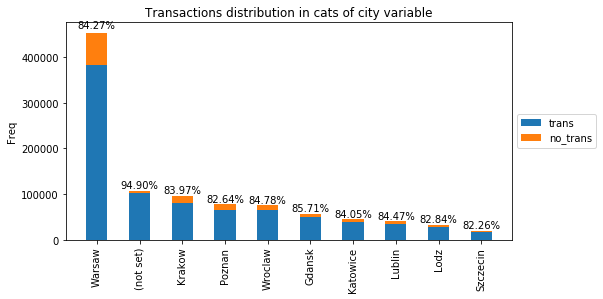

        city  procent_klikniec
1  (not set)             94.90
5     Gdansk             85.71
4    Wroclaw             84.78
7     Lublin             84.47
0     Warsaw             84.27
6   Katowice             84.05
2     Krakow             83.97
8       Lodz             82.84
3     Poznan             82.64
9   Szczecin             82.26


In [28]:
basic_stat(data_raw, 'city')

In [19]:
big_cities = ['Piotrkow Trybunalski', 'Bedzin', 'Belchatow', 'Bialystok', 'Bielsk Podlaski', 'Bielsko-Biala', 'Bilgoraj', 'Bochnia', 'Boleslawiec', 'Brodnica', 'Bydgoszcz', 'Bytom', 'Carlow', 'Chelm', 'Chojnice', 'Chorzow', 'Chrzanow', 'Ciechanow', 'Cieszyn', 'Czerwionka-Leszczyny', 'Czestochowa', 'Dabrowa Gornicza', 'Debica', 'Elblag', 'Elk', 'Gdansk', 'Gdynia', 'Gliwice', 'Glogow', 'Gniezno', 'Gorlice', 'Gorzow Wielkopolski', 'Grodzisk Mazowiecki', 'Grudziadz', 'Ilawa', 'Inowroclaw', 'Jaroslaw', 'Jaslo', 'Jastrzebie-Zdroj', 'Jawor', 'Jaworzno', 'Jelenia Gora', 'Kalisz', 'Kamienna Gora', 'Katowice', 'Kielce', 'Kolobrzeg', 'Konin', 'Koszalin', 'Krakow', 'Krasnik', 'Krotoszyn', 'Kutno', 'Lebork', 'Leszno', 'Lodz', 'London', 'Lubin', 'Lublin', 'Lukow', 'Lviv', 'Malbork', 'Mielec', 'Mikolow', 'Minsk Mazowiecki', 'Mlawa', 'Myslowice', 'Myszkow', 'Nowy Dwor Mazowiecki', 'Nowy Sacz', 'Nowy Targ', 'Nysa', 'Olesnica', 'Olkusz', 'Olsztyn', 'Opole', 'Ostroda', 'Ostrow Wielkopolski', 'Oswiecim', 'Piaseczno', 'Piekary Slaskie', 'Pila', 'Plock', 'Poznan', 'Pruszkow', 'Przemysl', 'Pulawy', 'Raciborz', 'Radom', 'Radomsko', 'Ruda Slaska', 'Rumia', 'Rybnik', 'Rzeszow', 'Sandomierz', 'Sanok', 'Siedlce', 'Siemianowice Slaskie', 'Sieradz', 'Skarzysko-Kamienna', 'Skierniewice', 'Slupsk', 'Sochaczew', 'Sopot', 'Sosnowiec', 'Stalowa Wola', 'Starachowice', 'Starogard Gdanski', 'Staszow', 'Suwalki', 'Swidnica', 'Swidnik', 'Swietochlowice', 'Swinoujscie', 'Szczecin', 'Tarnobrzeg', 'Tarnow', 'Tczew', 'Tomaszow Mazowiecki', 'Torun', 'Tychy', 'Walbrzych', 'Walcz', 'Warsaw', 'Warstein', 'Wejherowo', 'Wloclawek', 'Wodzislaw Slaski', 'Wolomin', 'Wroclaw', 'Wrzesnia', 'Wyszkow', 'Zabrze', 'Zamosc', 'Zary', 'Zawiercie', 'Zdunska Wola', 'Zgierz', 'Zielona Gora', 'Zyrardow', 'Zywiec', 'Backnang', 'Bartoszyce', 'Biala Podlaska', 'Bristol', 'Brzeg', 'Christchurch', 'Copenhagen', 'Delft', 'Dublin', 'Frankfurt', 'Ghent', 'Gizycko', 'Hamburg', 'Jarocin', 'Kedzierzyn-Kozle', 'Ketrzyn', 'Klodzko', 'Kluczbork', 'Knurow', 'Kwidzyn', 'Legnica', 'Lomza', 'Lowicz', 'Lubon', 'Malmo', 'Miami', 'Olawa', 'Ostroleka', 'Saarbrucken', 'Soest', 'Stargard', 'Swarzedz', 'Swiecie', 'Tarnowskie Gory', 'Vienna', 'Wola', 'Wolverhampton', 'Zagan', 'Zgorzelec', 'Zory', 'Bayreuth', 'Gothenburg', 'Pabianice', 'Police', 'Pszczyna', 'Stuttgart', 'Canterbury', 'Jaen', 'Regensburg', 'Sodertalje', 'Stockholm', 'Tilburg', 'Zanzibar', 'Augustow', 'Barcelona', 'Bergamo', 'Birmingham', 'Bremerhaven', 'Leipzig', 'Liverpool', 'New York', 'Oelde', 'Reading', 'Split', 'Zakopane', 'Witten', 'Colombo', 'Alcobendas', 'Cardiff', 'Kaunas', 'Madrid', 'Nowa Sol', 'Otwock', 'Swords', 'Uelzen', 'Unterschleissheim', 'Vantaa', 'Bad Homburg', 'Czechowice-Dziedzice', 'Essen', 'Paris', 'Wolow', 'Hradec Kralove', 'Mannheim', 'Wolfsburg', 'Hilversum', 'Dover', "'s Hertogenbosch", 'Athens', 'Lausanne', 'Littleton', 'Szczecinek', 'Zapopan', 'Amsterdam', 'Antwerp', 'Budapest', 'Duisburg', 'Halmstad', 'Julich', 'Kassel', 'Kerpen', 'Legionowo', 'Lelystad', 'Liberec', 'Neath', 'Norderstedt', 'Rotterdam', 'Schwabisch Hall', 'Kettering', 'Ostrowiec', 'Remscheid', 'Konigswinter', 'Alphen aan den Rijn', 'Czeladz', 'Dakar', 'Dubai', 'Glubczyce', 'Ingolstadt', 'Munich', 'Nuremberg', 'Potsdam', 'Watford', 'Brest', 'Brussels', 'Darmstadt', 'Mississauga', 'Alimos', 'Bognor Regis', 'Chicago', 'Edinburgh', 'Edmonton', 'Heidelberg', 'Itzehoe', 'Kempten', 'Kyiv', 'Martin', 'Redditch', 'Wakefield', 'Hel', 'Kharkiv', 'Barysaw', 'Bayonne', 'Cologne', 'Los Angeles', 'Minsk', 'Rio de Janeiro', 'The Hague', 'Dnipro', 'Odesa', 'Oxford', 'Rome', 'Ternopil', 'Vaxjo', 'Reykjavik', 'Neustadt', 'Pforzheim', 'Berlin', 'Dzierzoniow', 'Huesca', 'Cleckheaton', 'Mantes-la-Jolie', 'Venlo', 'Bratislava', 'Bridgwater', 'Helsinki', 'Kryvyi Rih', 'Neuwied', 'Siegen', 'Slough', 'Alcorcon', 'Almere', 'Banska Bystrica', 'Esslingen', 'Geilenkirchen', 'Grodno', "Irpin'", 'Kakhovka', 'Milan', 'Nordhorn', 'Osaka', 'Prague', 'Preston', 'Randers', 'Rochdale', 'Russelsheim', 'Baerum', 'Corby', 'Graz', 'Hemer', 'Landgraaf', 'Odense', 'Buxtehude', 'Bern', 'Botkyrka', 'Buchholz in der Nordheide', 'Hamilton', 'Limassol', 'Neumunster', 'Solingen', 'St Albans', 'Vilnius', 'Zurich', 'Middlesbrough', 'Oudenaarde', 'Aberdeen', 'Belfast', 'Manchester', 'Chester', 'Karlsruhe', 'Caerphilly', 'Parla', 'Sale', 'Toronto', 'Recklinghausen', 'Zagreb', 'Seraing', 'Halle (Saale)', 'Kaiserslautern', 'Naples', 'Ulaanbaatar', 'Galway', 'Longueuil', 'Munster', 'Aarhus', 'Bolton', 'Chernivtsi', 'Crewe', 'Gyor', 'Springe', 'Sydney', 'Kopavogur', 'Giessen', 'Mulheim', 'Leinfelden-Echterdingen', 'Leverkusen', 'Leeds', 'New Lenox', 'Wolfenbuttel', 'Kalush', 'Ashburn', 'Yuzhno-Sakhalinsk', 'Kaarst', 'Frederiksberg', 'Aurora', 'Lisbon', 'Zvolen', 'Chorley', 'Cloppenburg', 'Dusseldorf', 'Offenbach', 'Telford', 'Hurghada', 'Yalta', 'Kevelaer', 'Brasschaat', 'Hanover', 'Bielawa', 'Florence', 'Jakarta', 'Minneapolis', 'Ede', 'Bruges', 'Moscow', 'Noida', 'Lommel', 'Tampere', 'Montreal', 'Gorlitz', 'Dopiewo', 'Hollabrunn', 'Biel/Bienne', 'Rheda-Wiedenbruck', 'Singen', 'Lyon', 'Volklingen', 'Kamen', 'Offenburg', 'Schwenningen', 'Karlsbad', 'Nottingham', 'Worthing', 'Bletchley', 'Gloucester', 'Aalst', 'Bielefeld', 'Trollhattan', 'Haarlem', 'Hann. Munden', 'Ipswich', 'Olpe', 'Tiel', 'Wiesbaden', 'Wernigerode', 'Wunstorf', 'Erding', 'Ostrava', 'Ahlen', 'Heerhugowaard', 'Lingen', 'Linkoping', 'Castrop-Rauxel', 'Narbonne', 'Oss', 'Oberhausen', 'Rottweil', 'Nordenham', 'Dunfermline', 'Southampton', 'Oshawa', 'Herrenberg', 'Praia', 'Abu Dhabi', 'Palermo', 'Luneburg', 'Bad Nauheim', 'Bamberg', 'Ratingen', 'Aalen', 'Cesky Tesin', 'Alicante', 'Bretten', 'Calgary', 'Erftstadt', 'Helmond', 'Larnaca', 'Nurtingen', 'Rugby', 'Utrecht', 'Hildesheim', 'Mainz', 'Winterthur', 'Wuppertal', 'Austin', 'Bergen op Zoom', 'Eindhoven', 'Lowestoft', 'Manama', 'Merida', 'Prievidza', 'Trier', 'Aachen', 'Ras Al-Khaimah', 'Fulda', 'Dudley', 'Geneva', 'Genoa', 'Glasgow', 'Haifa', 'Lage', 'Liptovsky Mikulas', 'Villejuif', 'Wegberg', 'Hartford', 'Garfield', 'Monroe Township', 'Leonberg', 'Friedrichshafen', 'Saarlouis', 'Las Palmas de Gran Canaria', 'Rastatt', 'Langenhagen', 'Bucharest', 'Eastleigh', 'Hameenlinna', 'Metz', 'Almaty', 'Crailsheim', 'Walsall', 'Huddinge', 'Stade', 'Basel', 'Bergisch Gladbach', 'Boblingen', 'Newark', 'Tel Aviv-Yafo', 'Halle', 'Naucalpan de Juarez', 'Salon-de-Provence', 'Witney', 'Huckelhoven', 'Houston', 'Grenoble', 'Rana Municipality', 'Bradford', 'Bremen', 'Gouda', 'Blackburn', 'Goppingen', 'Arona', 'Salerno', 'San Francisco', 'Ceske Budejovice', 'Hull', 'Koniz', 'Washington', 'Exeter', 'Flensburg', 'Rosario', 'Balingen', 'Capelle aan den IJssel', 'Luton', 'Brunswick', 'Ha Municipality', 'Lohne', 'Werl', "King's Lynn", 'Leiden', 'Royal Leamington Spa', 'Drogheda', 'Gronau', 'Hurth', 'Turin', 'Vejle', 'Catanzaro', 'Waregem', 'Bullhead City', 'Lund', 'Nienburg', 'Neuss', 'Emden', 'Brno', 'Passaic', 'Vitoria-Gasteiz', 'Bochum', 'Perugia', 'Sighisoara', 'Duren', 'Nairobi', 'Marburg', 'Neuruppin', 'Oldenburg', 'Pinneberg', 'Izegem', 'Koblenz', 'Doha', 'Innsbruck', 'Kiel', 'Dundee', 'Colchester', 'Lecce', 'Northampton', 'Bad Zwischenahn', 'Lippstadt', 'Vechta', 'Augsburg', 'Brighton', 'Barrow-in-Furness', 'Waltrop', 'Neustadt am Rubenberge', 'Bologna', 'Barendrecht', 'Hafnarfjordur', 'Hanoi', 'Veendam', 'Philadelphia', 'Dordrecht', 'Neuburg an der Donau', 'Peterborough', 'Langenfeld', 'Nanterre', 'Sheffield', 'Erkelenz', 'Slobozia', 'Dortmund', 'Burton upon Trent', 'Chur', 'Cluj-Napoca', 'Coventry', 'Freiburg', 'Holbaek', 'Johannesburg', 'Rodgau', 'Asnieres-sur-Seine', 'Aylesbury', 'Frechen', 'Gatineau', 'Grimsby', 'Haltern am See', 'Heinsberg', 'Limerick', 'Neu-Ulm', 'Oak Lawn', 'Oer-Erkenschwick', 'Palm Bay', 'Silkeborg', 'Vancouver', 'Wittenberg', 'Detmold', 'Gummersbach', 'Hvidovre', 'Ravensburg', 'Dongen', 'Dresden', 'Herne', 'Bolzano', 'Hof', 'Krefeld', 'Barnsley', 'Milton', 'Schwabisch Gmund', 'Cairo', 'Hengelo', 'Stratford-upon-Avon', 'Harlow', 'Manacor', 'Sofia', 'Groningen', 'Mykolaiv', 'Buhl', 'Compiegne', 'Wermelskirchen', 'Leusden', 'Klaipeda', 'Ljubljana', 'Syracuse', 'Vilvoorde', 'Wurzburg', 'Uherske Hradiste', 'Venice', 'Puerto Plata', 'Saint-Jerome', 'San Jose', 'Bad Neuenahr-Ahrweiler', 'Bruchsal', 'Heist-op-den-Berg', 'Lorrach', 'Monchengladbach', 'Oakville', 'Schmallenberg', 'Terneuzen', 'Wesseling', 'Nykoping', 'Sint-Niklaas', 'Overath', 'Bunde', 'Cambridge', 'Crawley', 'Newport', 'Greven', 'Debrecen', 'Visaginas', 'Emmendingen', 'Osnabruck', 'Teplice', 'Bornheim', 'West Chicago', 'Cham', 'Sankt Ingbert', 'Argenteuil', 'Bangkok', 'Berat', 'Lubeck', 'Sankt Wendel', 'Brossard', 'Nicosia', 'Lincoln', 'Gifhorn', 'Guangzhou', 'Valladolid', 'Bad Hersfeld', 'Butzbach', 'Hattingen', 'Ho Chi Minh City', 'Reichshof', 'Sint-Truiden', 'Tunis', 'Helsingborg', 'West Palm Beach', 'Des Plaines', 'Loughborough', 'Viborg', 'Worms', 'Ahrensburg', 'Zrenjanin', 'Mosbach', 'Seville', 'Senigallia', 'Bergkamen', 'Konigsbrunn', 'Rivne', 'Rotherham', 'Thessaloniki', 'Verona', 'Houthalen-Helchteren', 'Adelaide', 'Kerkrade', 'Leuven', 'Trento', 'Lokeren', 'Papenburg', 'Spijkenisse', 'Presov', 'Neumarkt in der Oberpfalz', 'Frankfurt an der Oder', 'Spisska Nova Ves', 'Stendal', 'Aalborg', 'Brunssum', 'Landsberg am Lech', 'Karlskrona', 'Zirndorf', 'Celle', 'Crevillent', 'Goch', 'Goes', 'Hoek', 'St. Louis', 'Coesfeld', 'Deggendorf', 'Irkutsk', 'Issy-les-Moulineaux', 'Nes', 'Pa Tong', 'Paignton', 'Woodstock', 'Barrie', 'Brandon', 'Macau', 'Quinte West', 'West Chester', 'Emsdetten', 'Prato', 'Schweinfurt', 'Marrakesh', 'Montpellier', 'Riccione', 'Camarillo', 'Foggia', 'La Prairie', 'Horn', 'Brasov', 'Iasi', 'Monheim am Rhein', 'Mons', 'Saint-Maur-des-Fosses', 'Zalaegerszeg', 'Basingstoke', 'Vicenza', 'Rezekne', 'Orebro', 'Maisons-Alfort', 'Lille', 'Porta Westfalica', 'Kampen', 'Monaco-Ville', 'Tashkent', 'Alcala de Henares', 'Geel', 'Besancon', 'Laval', 'Lawrenceville', 'Bautzen', "Villeneuve-d'Ascq", 'Villingen-Schwenningen', 'Biberach', 'Trencin', 'Achinsk', 'Zilina', 'Unna', 'Wiehl', 'Bethesda', 'Brookfield', 'Maintal', 'Oosterhout', 'San Diego', 'Targu Mures', 'Vinnytsia', 'Boston', 'Epe', 'Filderstadt', 'Hitchin', 'Limbach-Oberfrohna', 'Maastricht', 'Montauban', 'Rauma', 'Visakhapatnam', 'Zaragoza', 'Falkirk', 'Lubbecke', 'Murcia', 'Schaumburg', 'Stevenage', 'Buffalo', 'Hoorn', 'Formigine', 'Saint-Quentin', 'Lam', 'Delbruck', 'Howell', 'Kitchener', 'Reggio Calabria', 'Beirut', 'Ilmenau', 'Kavlinge', 'Las Vegas', "Pomigliano d'Arco", 'Kolding', 'Dendermonde', 'Havirov', 'Karlovy Vary', 'Steyr', 'Krasnodar', 'Saint Petersburg', 'Dorsten', 'Mombasa', 'St Helens', 'Panevezys', 'Hattersheim am Main', 'Montreuil', 'West Linn', 'Boras', 'Marsta', 'Maubeuge', 'Saint Austell', 'Trutnov', 'Wheaton', 'Amiens', 'Halifax', 'Valdemoro', 'Tonbridge', 'Porvoo', 'Zoetermeer', 'Truskavets', 'Cannes', 'Langreo', 'Portland', 'Arlon', 'Heemskerk', 'Hove', 'Limburg', 'Camberley', 'Frydek-Mistek', 'Merzig', 'Folkestone', 'Menomonee Falls', 'Tartu', 'Datteln', 'Velletri', 'Concord', 'Torquay', 'Lahr', 'Creteil', 'Danbury', 'Franklin Township', 'Louisville', 'Orleans', 'Saratoga Springs', 'Emmerich', 'Bloomfield Township', 'Vitoria da Conquista', 'Tbilisi', 'De Lier', 'Plauen', 'Richmond', 'Trelleborg', 'Lutsk', 'Centereach', 'Holon', 'Lennestadt', 'Ilkeston', 'Wellington', 'Sassari', 'Langen', 'Jonkoping', 'Schwerin', 'Yokohama', 'Wilmslow', 'Cachan', 'Waiblingen', 'Mazeikiai', 'Steinfurt', 'Kecskemet', 'Baesweiler', 'Beringen', 'Erfurt', 'Nijmegen', 'Parma', 'Karvina', 'Addis Ababa', 'Amberg', 'Banbury', 'Bezons', 'Carpentersville', 'Evry', 'Gladbeck', 'Glendale Heights', 'Hyderabad', 'Kristianstad', 'Legnano', 'Livingston', 'Ludwigsburg', 'Memmingen', 'New Tecumseth', 'Perth', 'Phnom Penh', 'Phoenix', 'Pretoria', 'Saint Thomas', 'San Juan Cuautlancingo', 'Sayreville', 'Sindelfingen', 'Solna', 'Toulouse', 'Tourcoing', 'West Islip', 'Ahaus', 'Aix-en-Provence', 'Angri', 'Aveiro', 'Badalona', 'Bath', 'Brilon', 'Caen', 'Campobasso', 'Cascais', 'Cergy', 'Chartres', 'Epinal', 'Forchheim', 'Gaggenau', 'Guildford', 'Harrogate', 'Hartlepool', 'Haskovo', 'Herning', 'High Wycombe', 'Hoi An', 'Holyoke', 'Horsens', 'Imperia', 'Ivano-Frankivsk', 'Kennesaw', 'La Louviere', 'Landskrona', 'Leichlingen', 'Madison', 'Malaga', 'March', 'Martigues', 'Miami Beach', 'Modena', 'Motril', 'Nordhausen', 'Oradea', 'Osterholz-Scharmbeck', 'Papa', 'Plainfield', 'Pozuelo de Alarcon', 'Reus', 'Rosrath', 'Runcorn', 'Saint Andrews', 'Saintes', 'Salzburg', 'Shanghai', 'Sopron', 'Stockport', 'Swansea', 'Taranto', 'Torrevieja', 'Usti nad Labem', 'Vac', 'Valkenswaard', 'Vocklabruck', 'Waterford', 'West Bromwich', 'York', 'Zweibrucken', 'Clacton-on-Sea', 'Jesenik', 'Joliet', 'Monroe', 'Mulhouse', 'Ubud', 'Vasteras', 'Aldershot', 'Bollnas', 'Drohobych', 'Jarvenpaa', 'Kostyantynivka', 'Pamplona', 'Stralsund', 'Stryi', 'Georgsmarienhutte', 'Morecambe', 'Oujda', 'Sumperk', 'Opava', 'Bergen', 'Clydebank', 'Horst', 'Viersen', 'Baunatal', 'Baltimore', 'Marbella', 'Skelmersdale', 'West Babylon', 'Farnborough', 'Skopje', 'Wrexham', 'Orlova', 'Elk Grove Village', 'Port Moody', 'Blankenfelde-Mahlow', 'Montevideo', 'Sundbyberg', 'Southend-on-Sea', 'San Isidro', 'Meriden', 'Buenos Aires', 'Kayseri', 'Burlington', 'Eger', 'Roth', 'Damascus', 'Kraljevo', 'Rheine', 'Antakya', 'Krasnoyarsk', 'Garbsen', 'Reutlingen', 'Astrakhan']

In [42]:
data_raw['city size'] = ['big city' if (i in big_cities) else 'small city' for i in data_raw.city.values]

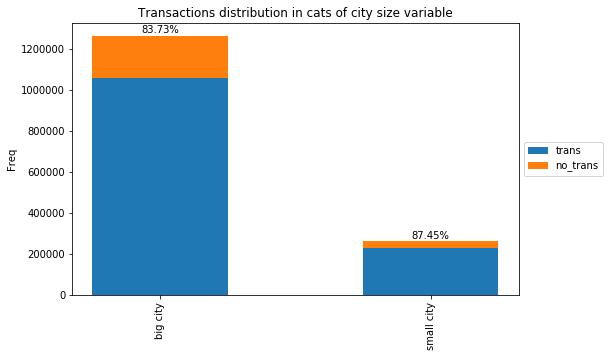

    city size  procent_klikniec
1  small city             87.45
0    big city             83.73


In [50]:
basic_stat(data_raw, 'city size')

# Podział na segmenty

In [58]:
segm_1 = data_raw[(~data_raw.city.isin(big_cities)) &(data_raw.landing_page_length<=1)]
segm_2 = data_raw[(data_raw.city.isin(big_cities)) &(data_raw.landing_page_length<=1)]
segm_3 = data_raw[(data_raw.channel=='Email Owned')  &(data_raw.landing_page_length>1)]
segm_4 = data_raw[(data_raw.channel!='Email Owned')  &(data_raw.landing_page_length>1)]

In [59]:
perc = [len(segm_1[segm_1.transactions_bin==1])/len(segm_1), len(segm_2[segm_2.transactions_bin==1])/len(segm_2), 
len(segm_3[segm_3.transactions_bin==1])/len(segm_3), len(segm_4[segm_4.transactions_bin==1])/len(segm_4)]

udział procentowy transakcji w każdym z segmentów

In [60]:
trans_segments = pd.DataFrame(data={
    'nobs':[len(segm_1), len(segm_2), len(segm_3), len(segm_4)],
    'trans_count':[len(segm_1[segm_1.transactions_bin==1]), len(segm_2[segm_2.transactions_bin==1]), len(segm_3[segm_3.transactions_bin==1]), len(segm_4[segm_4.transactions_bin==1])],
    'trans_perc': perc
}, index=['seg 1', 'seg 2', 'seg 3', 'seg 4'])
trans_segments

,nobs,trans_count,trans_perc
seg 1,66718,61330,0.919242
seg 2,37561,3863,0.102846
seg 3,292162,222088,0.760154
seg 4,1129106,999822,0.885499


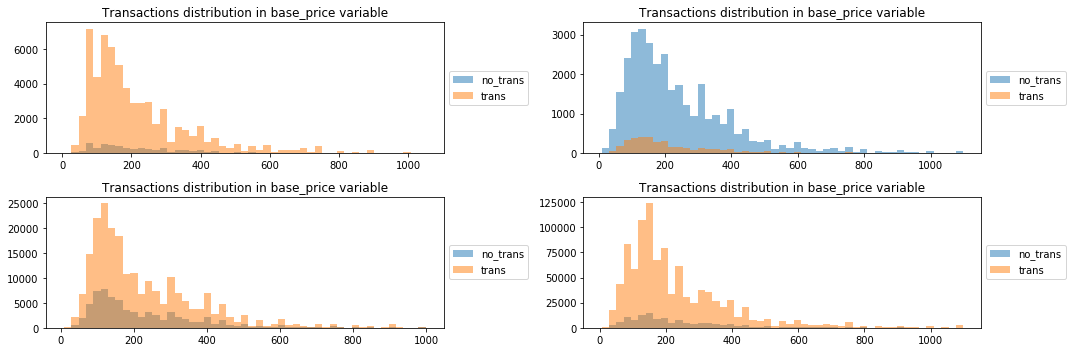

In [100]:
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
basic_stat(segm_1, 'base_price',show=False, detailed=False)
plt.subplot(2,2,2)
basic_stat(segm_2, 'base_price', show=False, detailed=False)
plt.subplot(2,2,3)
basic_stat(segm_3, 'base_price', show=False, detailed=False)
plt.subplot(2,2,4)
basic_stat(segm_4, 'base_price', show=False, detailed=False)
plt.tight_layout()
plt.show()

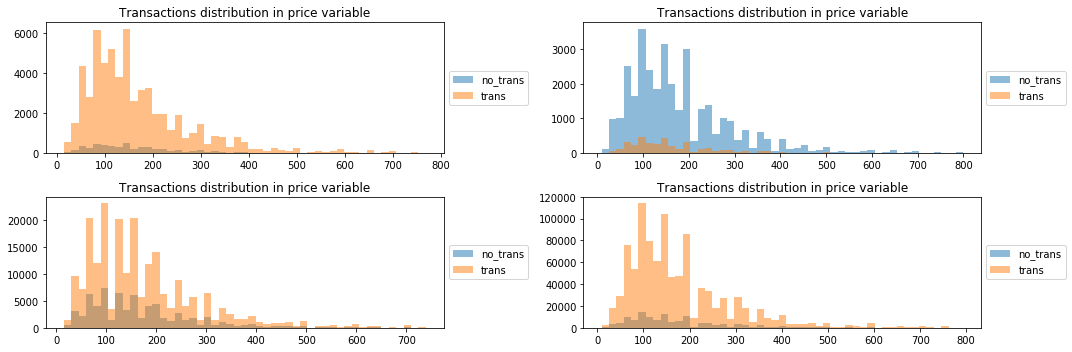

In [101]:
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
basic_stat(segm_1, 'price',show=False, detailed=False)
plt.subplot(2,2,2)
basic_stat(segm_2, 'price', show=False, detailed=False)
plt.subplot(2,2,3)
basic_stat(segm_3, 'price', show=False, detailed=False)
plt.subplot(2,2,4)
basic_stat(segm_4, 'price', show=False, detailed=False)
plt.tight_layout()
plt.show()

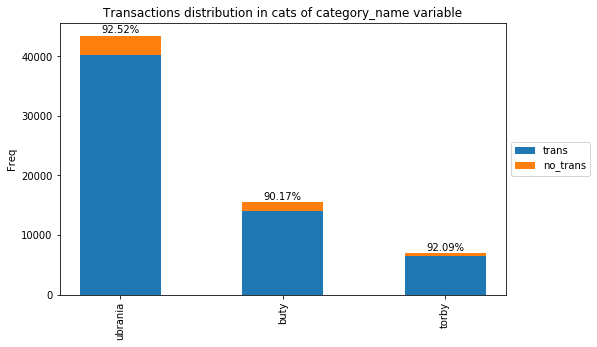

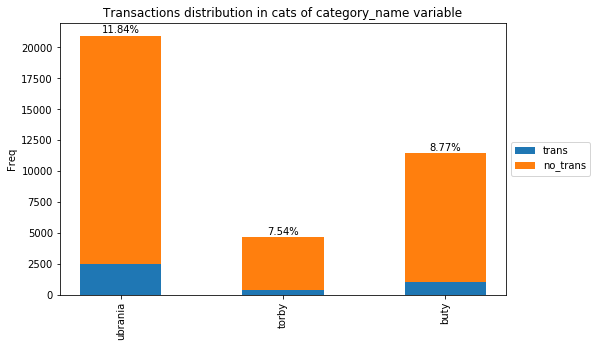

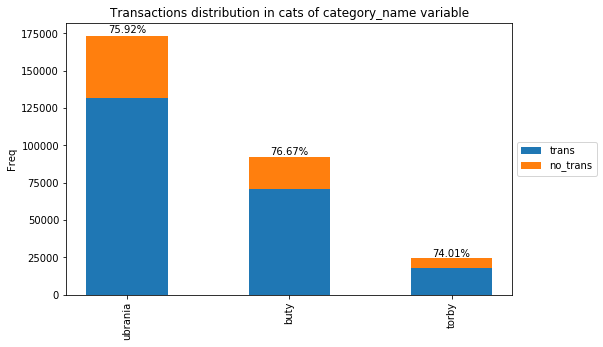

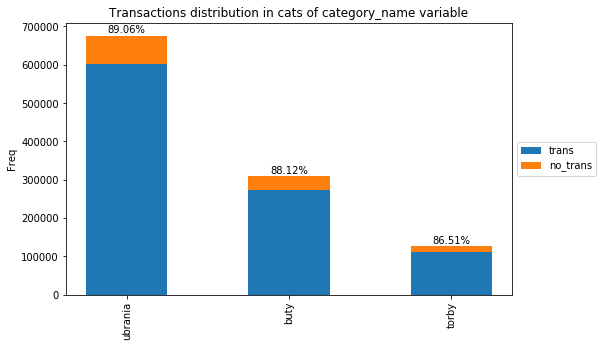

In [120]:
basic_stat(segm_1, 'category_name',show=False, detailed=False)
basic_stat(segm_2, 'category_name', show=False, detailed=False)
basic_stat(segm_3, 'category_name', show=False, detailed=False)
basic_stat(segm_4, 'category_name', show=False, detailed=False)
plt.show()

## Mapowanie klientów

plik shp z mapą województw wziąłem z https://gis-support.pl/granice-administracyjne/ , plik wojewodztwa

plik z mapowaniem miast po wojewodztwach wzialem z :http://blog.adiasz.pl/2009/08/04/lista-miejscowosci-w-polsce-z-podzialem-na-wojewodztwa-w-formacie-csv/

In [9]:
import string
def odkoduj(tekst):
    polskie = {"Ą":"A","Ć":"C",
"Ę":"E","Ł":"L","Ń":"N","Ó":"O",
"Ś":"S","Ź":"Z","Ż":"Z","ą":"a",
"ć":"c","ę":"e","ł":"l","ń":"n",
"ó":"o","ś":"s","ź":"z","ż":"z"}
    for i in tekst:
        for key in polskie.keys():
            if i==key:
                tekst = tekst.replace(i,polskie[key])
    return tekst

In [10]:
wojew = pd.read_csv("C:\\Users\\Rafal\\Downloads\\places.csv", sep=';', header=None, names=["id", "woj","miasto"])

In [11]:
wojew.miasto = [odkoduj(wojew.miasto[i]) for i in wojew.index]
wojew.loc[wojew.miasto=='Warszawa','miasto']='Warsaw'

In [31]:
cities = data_raw[data_raw.city.isin(wojew.miasto)]

strata okolo 140 tys obserwacji

In [47]:
len(cities), len(data_raw)

(1382968, 1525547)

In [32]:
cities_with_woj = pd.merge(cities, wojew[['miasto', 'woj']], left_on='city', right_on='miasto',how='left')

In [37]:
woj_df = pd.DataFrame(data={
    'woj_id':list(range(1,17)),
    'nowe_id': [7, 2, 14, 12, 9, 11, 3, 0, 13, 10, 15, 4, 1, 5, 8, 6],
    'woj_name':['Dolnoslaskie', 'Kujawsko-pomorskie', 'Lubelskie', 'Lubuskie', 'Lodzkie', 'Malopolskie', 'Mazowieckie', 'Opolskie', 'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Slaskie', 'Swietokrzyskie', 'Warminsko-mazurskie', 'Wielkopolskie', "Zachodniopomorskie"],
    'ilosc klientow (tys)':[len(cities_with_woj[cities_with_woj.woj==i])/1000 for i in range(1,17)],
    'procent_transakcji':[len(cities_with_woj[(cities_with_woj.woj==i) & (cities_with_woj.transactions_bin==1)])/len(cities_with_woj[(cities_with_woj.woj==i)])*100 for i in range(1,17)],
    'procent_wszystkich_transakcji':[len(cities_with_woj[(cities_with_woj.woj==i) & (cities_with_woj.transactions_bin==1)])/len(cities_with_woj[cities_with_woj.transactions_bin==1])*100 for i in range(1,17)]
})
woj_df.head()

,woj_id,nowe_id,woj_name,ilosc klientow (tys),procent_transakcji,procent_wszystkich_transakcji
0,1,7,Dolnoslaskie,96.560,84.132146,6.928768
1,2,2,Kujawsko-pomorskie,46.917,80.456977,3.219517
2,3,14,Lubelskie,60.904,83.244122,4.324104
3,4,12,Lubuskie,13.140,82.222222,0.921470
4,5,9,Lodzkie,52.298,83.177177,3.710104


In [34]:
woj_df.procent_wszystkich_transakcji.sum()

100.0

In [14]:
import shapefile as shp
import seaborn as sns
shp_path = "C:\\Users\\Rafal\\Desktop\\machine_learning\\mckinsey_lamoda\\EDA\\wojewodztwa\\województwa.shp"
sf = shp.Reader(shp_path)

In [15]:
def calc_color(data, color=None):
        if color == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']
            colors = 'Purples'
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']
            colors = 'YlGnBu'
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']
            colors = 'Greys'
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']
            colors = 'YlOrBr'
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6)
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins

In [16]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9), detail=False, df=None):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[id])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            if not detail:
                plt.text(x0, y0, id, fontsize=10)
            if detail:
                plt.text(x0, y0, df[df['nowe_id']==int(id)].procent_transakcji, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [17]:
def plot_woj_data(sf, title, woj_id, data=None, 
                      color=None, print_id=False, detail=False, df=None):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    plot_map_fill_multiples_ids_tone(sf, title, woj_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9), detail=detail, df=df);


1: 11 => 21 
2: 22 => 33 
3: 34 => 48 
4: 49 => 83 
5: 84 => 121 
6: 122 => 498 

   1   2   3   4   5   6


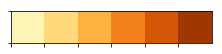

<Figure size 792x648 with 0 Axes>

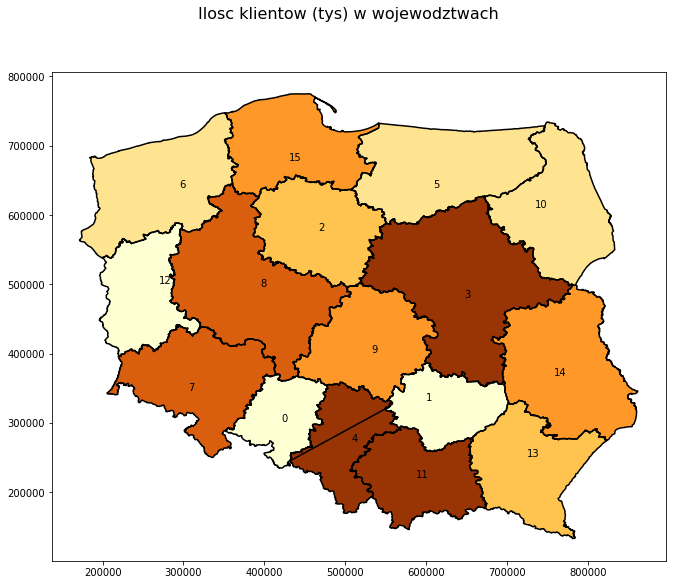

In [52]:
title = 'Ilosc klientow (tys) w wojewodztwach'
data = woj_df.sort_values('nowe_id')['ilosc klientow (tys)'].values
names = woj_df.sort_values('nowe_id').nowe_id
plot_woj_data(sf, title, names, data, 4, True)

In [177]:
woj_df.sort_values('procent_transakcji', ascending=False)

,woj_id,woj_name,ilosc klientow (tys),procent_transakcji,procent_wszystkich_transakcji,nowe_id
12,13,Swietokrzyskie,19.839,84.691769,1.433038,1
10,11,Pomorskie,84.062,84.589946,6.064783,15
6,7,Mazowieckie,499.000,84.170741,35.822713,3
0,1,Dolnoslaskie,96.560,84.132146,6.928768,7
8,9,Podkarpackie,44.904,83.783182,3.208771,13
5,6,Malopolskie,126.788,83.583620,9.038495,11
2,3,Lubelskie,60.904,83.244122,4.324104,14
4,5,Lodzkie,52.298,83.177177,3.710104,9
14,15,Wielkopolskie,118.137,83.135681,8.376646,8
11,12,Slaskie,146.370,83.034092,10.365859,4


#### Podział na zbiory dla segmentów

In [21]:
segm1_cities = segm_1[segm_1.city.isin(wojew.miasto)]
segm2_cities = segm_2[segm_2.city.isin(wojew.miasto)]
segm3_cities = segm_3[segm_3.city.isin(wojew.miasto)]
segm4_cities = segm_4[segm_4.city.isin(wojew.miasto)]

#### Strata obserwacji po odsianiu miast zagranicznych w segmencie 1
W 1 segmencie 92% obserwacji to w większości miasta zagraniczne, przez co po odsianiu względem zbioru miast z pliku pozostało tylko 7% obserwacji.

In [65]:
len(segm1_cities)/len(segm_1)

0.07001109145957612

In [71]:
segm_1[~segm_1.city.isin(wojew.miasto)].city.unique()

array(['(not set)', 'Hoogvliet Rotterdam', 'Navan', 'Emlichheim',
       'Mierzyn', 'Oslo Municipality', 'Przylep',
       'Saint Anton am Arlberg', 'Sulzberg', 'Tullamore', 'Waspik',
       'Biskupice Radlowskie', 'Krynica', 'Langley Township', 'Lochowo',
       'Brabrand', 'Marlow', 'New Ross', 'Sint-Gillis-Waas', 'Kaufungen',
       'Prien am Chiemsee', 'Schijndel', 'Baniocha',
       'Bergen Municipality', 'Beverstedt', 'Eupen', 'Graulhet',
       'Herzogenaurach', 'Neerpelt', 'Opfikon', 'Ovre Eiker Municipality',
       'Bad Hofgastein', 'Crimmitschau', 'Schwechat',
       'Sorum Municipality', 'Wognum', 'Blegny', 'Lindas Municipality',
       'Adelnau', 'Kitzingen', 'Kontich', 'Mountain View', 'Meckenbeuren',
       'Rabka', 'Stryn Municipality', 'Tarm', 'Terebovlya',
       'Kvam Municipality', 'Arbon', 'Ixelles', 'Woodbridge Township',
       'Balbriggan', 'Castleton', 'Edegem', 'Lurgan', 'Maulburg',
       'Melksham', 'Tittling', 'Zierenberg', 'Grossbeeren'], dtype=object)

In [77]:
len(segm_1[~segm_1.city.isin(wojew.miasto)])/len(segm_1)

0.9299889085404238

#### Strata obserwacji po odsianiu miast zagranicznych w segmencie 2

In [78]:
len(segm2_cities)/len(segm_2)

0.9855168925214983

W 2 segmencie jest zdecydowanie mniej miast zagranicznych - zaledwie ~1.5%

In [79]:
len(segm_2[~segm_2.city.isin(wojew.miasto)])/len(segm_2)

0.014483107478501638

#### Strata obserwacji po odsianiu miast zagranicznych w segmencie 3:

In [67]:
len(segm3_cities)/len(segm_3)

0.9464885919455645

W 3 segmencie udział miast zagranicznych to niewiele ponad 5%

In [80]:
len(segm_3[~segm_3.city.isin(wojew.miasto)])/len(segm_3)

0.05351140805443555

#### Strata obserwacji po odsianiu miast zagranicznych w segmencie 4:

In [68]:
len(segm4_cities)/len(segm_4)

0.9430044654797689

W 4 segmencie udział miast zagranicznych również wynosił ~5.6%

In [83]:
len(segm_4[~segm_4.city.isin(wojew.miasto)])/len(segm_4)

0.05699553452023105

łączna liczba klientów zagranicznych w całym zbiorze:

In [101]:
len(segm_1[~segm_1.city.isin(wojew.miasto)]) + len(segm_2[~segm_2.city.isin(wojew.miasto)]) + len(segm_3[~segm_3.city.isin(wojew.miasto)]) + len(segm_4[~segm_4.city.isin(wojew.miasto)])

142579

In [22]:
cities_with_woj_1 = pd.merge(segm1_cities, wojew[['miasto', 'woj']], left_on='city', right_on='miasto',how='left')
cities_with_woj_2 = pd.merge(segm2_cities, wojew[['miasto', 'woj']], left_on='city', right_on='miasto',how='left')
cities_with_woj_3 = pd.merge(segm3_cities, wojew[['miasto', 'woj']], left_on='city', right_on='miasto',how='left')
cities_with_woj_4 = pd.merge(segm4_cities, wojew[['miasto', 'woj']], left_on='city', right_on='miasto',how='left')

In [49]:
woj_df_seg1 = pd.DataFrame(data={
    'woj_id':list(range(1,17)),
    'nowe_id': [7, 2, 14, 12, 9, 11, 3, 0, 13, 10, 15, 4, 1, 5, 8, 6],
    'woj_name':['Dolnoslaskie', 'Kujawsko-pomorskie', 'Lubelskie', 'Lubuskie', 'Lodzkie', 'Malopolskie', 'Mazowieckie', 'Opolskie', 'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Slaskie', 'Swietokrzyskie', 'Warminsko-mazurskie', 'Wielkopolskie', "Zachodniopomorskie"],
    'ilosc klientow':[len(cities_with_woj_1[cities_with_woj_1.woj==i]) for i in range(1,17)],
    'procent_transakcji':[len(cities_with_woj_1[(cities_with_woj_1.woj==i) & (cities_with_woj_1.transactions_bin==1)])/len(cities_with_woj_1[(cities_with_woj_1.woj==i)])*100 for i in range(1,17)],
    'procent_wszystkich_transakcji':[len(cities_with_woj_1[(cities_with_woj_1.woj==i) & (cities_with_woj_1.transactions_bin==1)])/len(cities_with_woj_1[cities_with_woj_1.transactions_bin==1])*100 for i in range(1,17)]
})
woj_df_seg2 = pd.DataFrame(data={
    'woj_id':list(range(1,17)),
    'nowe_id': [7, 2, 14, 12, 9, 11, 3, 0, 13, 10, 15, 4, 1, 5, 8, 6],
    'woj_name':['Dolnoslaskie', 'Kujawsko-pomorskie', 'Lubelskie', 'Lubuskie', 'Lodzkie', 'Malopolskie', 'Mazowieckie', 'Opolskie', 'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Slaskie', 'Swietokrzyskie', 'Warminsko-mazurskie', 'Wielkopolskie', "Zachodniopomorskie"],
    'ilosc klientow':[len(cities_with_woj_2[cities_with_woj_2.woj==i]) for i in range(1,17)],
    'procent_transakcji':[len(cities_with_woj_2[(cities_with_woj_2.woj==i) & (cities_with_woj_2.transactions_bin==1)])/len(cities_with_woj_2[(cities_with_woj_2.woj==i)])*100 for i in range(1,17)],
    'procent_wszystkich_transakcji':[len(cities_with_woj_2[(cities_with_woj_2.woj==i) & (cities_with_woj_2.transactions_bin==2)])/len(cities_with_woj_2[cities_with_woj_2.transactions_bin==1])*100 for i in range(1,17)]
})
woj_df_seg3 = pd.DataFrame(data={
    'woj_id':list(range(1,17)),
    'nowe_id': [7, 2, 14, 12, 9, 11, 3, 0, 13, 10, 15, 4, 1, 5, 8, 6],
    'woj_name':['Dolnoslaskie', 'Kujawsko-pomorskie', 'Lubelskie', 'Lubuskie', 'Lodzkie', 'Malopolskie', 'Mazowieckie', 'Opolskie', 'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Slaskie', 'Swietokrzyskie', 'Warminsko-mazurskie', 'Wielkopolskie', "Zachodniopomorskie"],
    'ilosc klientow (tys)':[len(cities_with_woj_3[cities_with_woj_3.woj==i])/1000 for i in range(1,17)],
    'procent_transakcji':[len(cities_with_woj_3[(cities_with_woj_3.woj==i) & (cities_with_woj_3.transactions_bin==1)])/len(cities_with_woj_3[(cities_with_woj_3.woj==i)])*100 for i in range(1,17)],
    'procent_wszystkich_transakcji':[len(cities_with_woj_3[(cities_with_woj_3.woj==i) & (cities_with_woj_3.transactions_bin==1)])/len(cities_with_woj_3[cities_with_woj_3.transactions_bin==1])*100 for i in range(1,17)]
})
woj_df_seg4 = pd.DataFrame(data={
    'woj_id':list(range(1,17)),
    'nowe_id': [7, 2, 14, 12, 9, 11, 3, 0, 13, 10, 15, 4, 1, 5, 8, 6],
    'woj_name':['Dolnoslaskie', 'Kujawsko-pomorskie', 'Lubelskie', 'Lubuskie', 'Lodzkie', 'Malopolskie', 'Mazowieckie', 'Opolskie', 'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Slaskie', 'Swietokrzyskie', 'Warminsko-mazurskie', 'Wielkopolskie', "Zachodniopomorskie"],
    'ilosc klientow (tys)':[len(cities_with_woj_4[cities_with_woj_4.woj==i])/1000 for i in range(1,17)],
    'procent_transakcji':[len(cities_with_woj_4[(cities_with_woj_4.woj==i) & (cities_with_woj_4.transactions_bin==1)])/len(cities_with_woj_4[(cities_with_woj_4.woj==i)])*100 for i in range(1,17)],
    'procent_wszystkich_transakcji':[len(cities_with_woj_4[(cities_with_woj_4.woj==i) & (cities_with_woj_4.transactions_bin==1)])/len(cities_with_woj_4[cities_with_woj_4.transactions_bin==1])*100 for i in range(1,17)]
})


1: 109 => 155 
2: 156 => 191 
3: 192 => 302 
4: 303 => 329 
5: 330 => 415 
6: 416 => 647 

   1   2   3   4   5   6


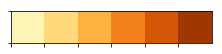

<Figure size 792x648 with 0 Axes>

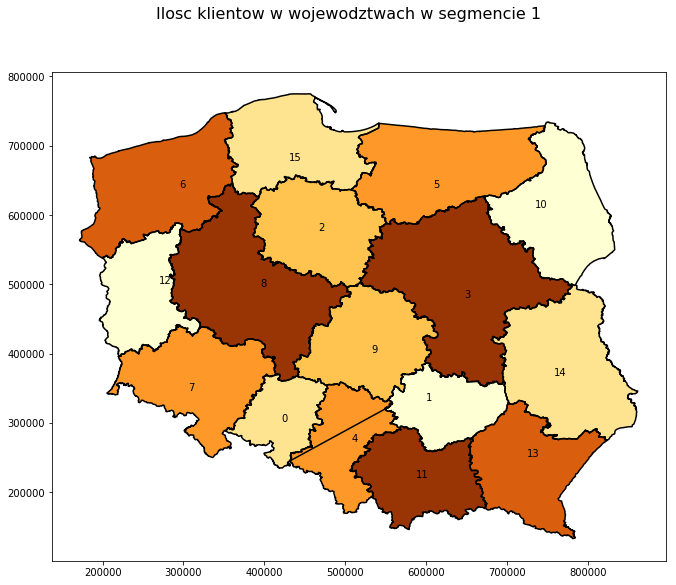

In [50]:
title = 'Ilosc klientow w wojewodztwach w segmencie 1'
data = woj_df_seg1.sort_values('nowe_id')['ilosc klientow'].values
names = woj_df_seg1.sort_values('nowe_id').nowe_id
plot_woj_data(sf, title, names, data, 4, True)

ciekawy jest fakt, że pomimo najwyzszego odsetka transakcji dla segmentu 1 sposrod wszystkich segmentow, dla miast polskich procent transakcji jest wyjatkowo niski - około 9.2%. Tak jakby w tym segmencie taka wysoka statystyke nabijaly miasta zagraniczne.

Polskie województwa średnio mają 9.24% transakcji wśród wszystkich wchodzących na stronę internetową, a zagraniczne miasta w tym segmencie 91.25%

In [100]:
foreign_segm_1 = segm_1[~segm_1.city.isin(wojew.miasto)]
woj_df_seg1.procent_transakcji.mean(), len(foreign_segm_1[foreign_segm_1.transactions_bin==1])/len(segm_1)*100

(9.236380058313431, 91.25123654785816)

In [86]:
woj_df_seg1.sort_values('procent_wszystkich_transakcji', ascending=False).head()

,woj_id,nowe_id,woj_name,ilosc klientow,procent_transakcji,procent_wszystkich_transakcji
8,9,13,Podkarpackie,374,16.310160,13.406593
14,15,8,Wielkopolskie,648,8.950617,12.747253
5,6,11,Malopolskie,539,9.647495,11.428571
1,2,2,Kujawsko-pomorskie,298,16.442953,10.769231
15,16,6,Zachodniopomorskie,399,10.776942,9.450549


mapowanie 2 segmentu


1: 216 => 572 
2: 573 => 925 
3: 926 => 1361 
4: 1362 => 2246 
5: 2247 => 3188 
6: 3189 => 13480 

   1   2   3   4   5   6


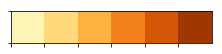

<Figure size 792x648 with 0 Axes>

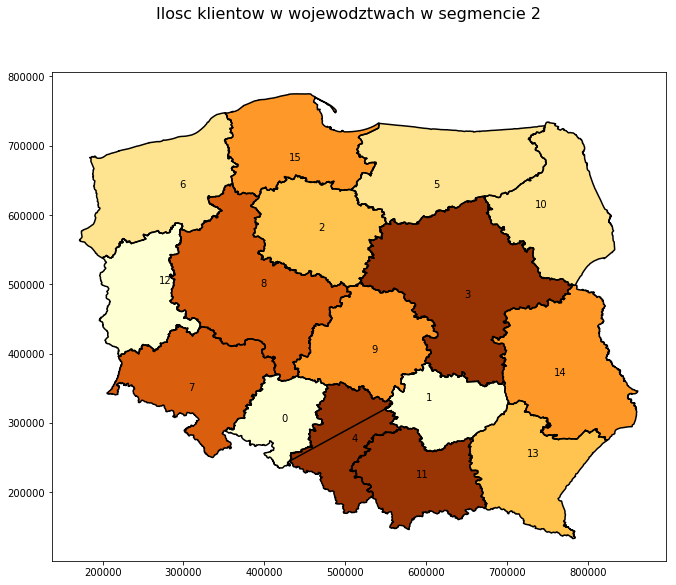

In [51]:
title = 'Ilosc klientow w wojewodztwach w segmencie 2'
data = woj_df_seg2.sort_values('nowe_id')['ilosc klientow'].values
names = woj_df_seg2.sort_values('nowe_id').nowe_id
plot_woj_data(sf, title, names, data, 4, True)

In [53]:
woj_df_seg2.sort_values('procent_transakcji', ascending=False).head()

,woj_id,nowe_id,woj_name,ilosc klientow,procent_transakcji,procent_wszystkich_transakcji
3,4,12,Lubuskie,361,16.343490,0.0
2,3,14,Lubelskie,1627,12.968654,0.0
6,7,3,Mazowieckie,13481,11.512499,0.0
7,8,0,Opolskie,216,11.111111,0.0
11,12,4,Slaskie,4090,11.002445,0.0



1: 2 => 3 
2: 4 => 6 
3: 7 => 8 
4: 9 => 17 
5: 18 => 23 
6: 24 => 93 

   1   2   3   4   5   6


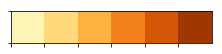

<Figure size 792x648 with 0 Axes>

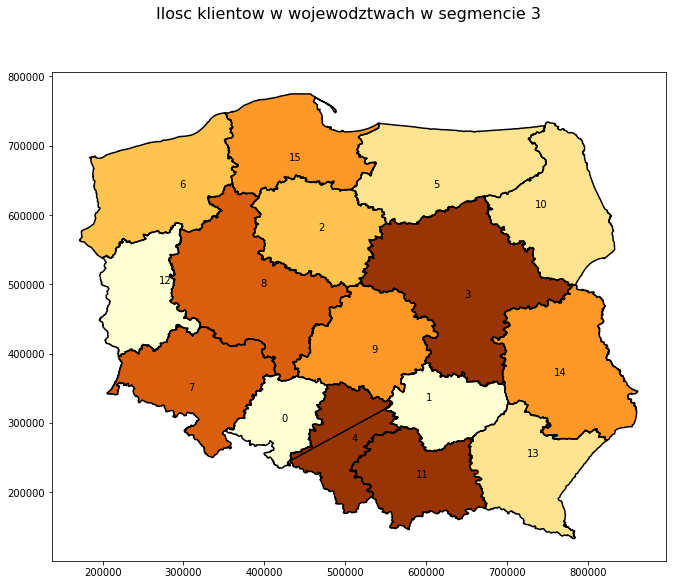

In [45]:
title = 'Ilosc klientow (tys) w wojewodztwach w segmencie 3'
data = woj_df_seg3.sort_values('nowe_id')['ilosc klientow (tys)'].values
names = woj_df_seg3.sort_values('nowe_id').nowe_id
plot_woj_data(sf, title, names, data, 4, True)

In [54]:
woj_df_seg3.sort_values('procent_transakcji', ascending=False).head()

,woj_id,nowe_id,woj_name,ilosc klientow (tys),procent_transakcji,procent_wszystkich_transakcji
1,2,2,Kujawsko-pomorskie,9.804,78.212974,3.592242
10,11,15,Pomorskie,18.170,77.853605,6.627003
4,5,9,Lodzkie,10.057,77.349110,3.644242
9,10,10,Podlaskie,4.446,76.518219,1.593741
0,1,7,Dolnoslaskie,21.460,76.453868,7.686218



1: 8 => 15 
2: 16 => 23 
3: 24 => 37 
4: 38 => 62 
5: 63 => 93 
6: 94 => 389 

   1   2   3   4   5   6


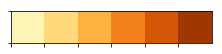

<Figure size 792x648 with 0 Axes>

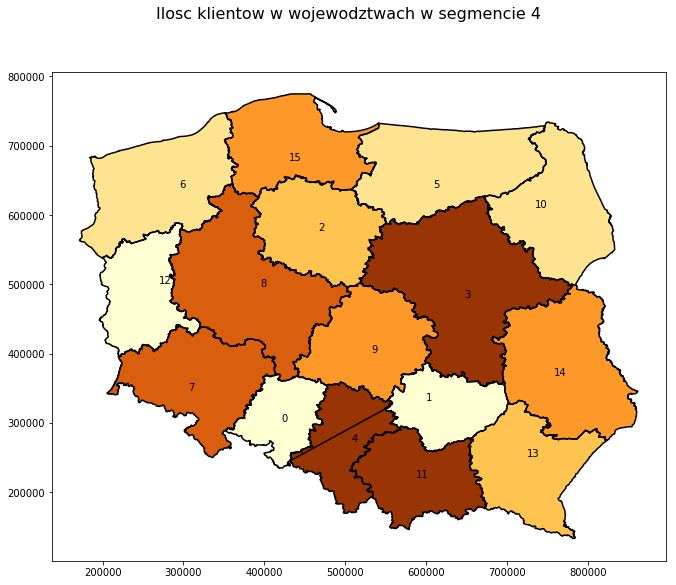

In [46]:
title = 'Ilosc klientow (tys) w wojewodztwach w segmencie 4'
data = woj_df_seg4.sort_values('nowe_id')['ilosc klientow (tys)'].values
names = woj_df_seg4.sort_values('nowe_id').nowe_id
plot_woj_data(sf, title, names, data, 4, True)

In [55]:
woj_df_seg4.sort_values('procent_transakcji', ascending=False).head()

,woj_id,nowe_id,woj_name,ilosc klientow (tys),procent_transakcji,procent_wszystkich_transakcji
12,13,1,Swietokrzyskie,15.326,90.271434,1.449124
0,1,7,Dolnoslaskie,72.185,89.438249,6.762332
10,11,15,Pomorskie,63.475,89.432060,5.945963
6,7,3,Mazowieckie,390.638,89.017453,36.423016
3,4,12,Lubuskie,8.982,88.900022,0.836375
